In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy, CategorialCorssEntropy, MeanSquareErrorLoss
from mygrad.optimizers import SGD , RMSProp, Adam
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import Trainer as RegressionTrainer, BinaryClassificationTrainer, CategoricalClassificationTrainer, ProgressBar, EarlyStopping
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

/tmp/ipykernel_28765/638924624.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# XOR 3

In [50]:
train_df = pd.read_csv("../mio1/classification/xor3-training.csv")
test_df = pd.read_csv("../mio1/classification/xor3-test.csv")

In [51]:
train_df.head()

,x,y,c
0,-5.720316,18.198653,0
1,50.039419,-71.390360,0
2,93.072781,-76.340256,0
3,10.434100,-21.863272,0
4,30.198218,-24.730234,0


Text(0.5, 1.0, 'Wizualizacja zbioru treningowego xor3')

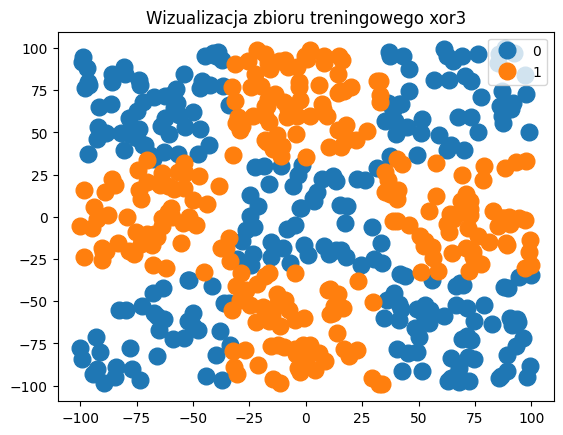

In [52]:
groups = train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru treningowego xor3")

In [53]:
X_train = train_df[["x", "y"]].values
y_train = train_df["c"].values.reshape(-1, 1) * 1

In [54]:
np.unique(y_train)

array([0, 1])

In [55]:
X_train.shape, y_train.shape

((500, 2), (500, 1))

In [56]:
input_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)

In [57]:
X_test = test_df[["x", "y"]].values
X_test_scaled = input_normalizer.transform(X_test)
y_test = test_df["c"].values.reshape(-1, 1) * 1

## Sigmoid

In [49]:
model = mc.Sequential(
    mc.Linear(2, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
    mc.Sigmoid(),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.001)
loss = BinaryCrossEntropy()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train, batch_size=20, shuffle=True)
validation_dataloader = NumpyRegressionDataloader(X_test_scaled, y_test, batch_size=100)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=200, metric="fscore", mode="max")
])
train_outputs = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 412


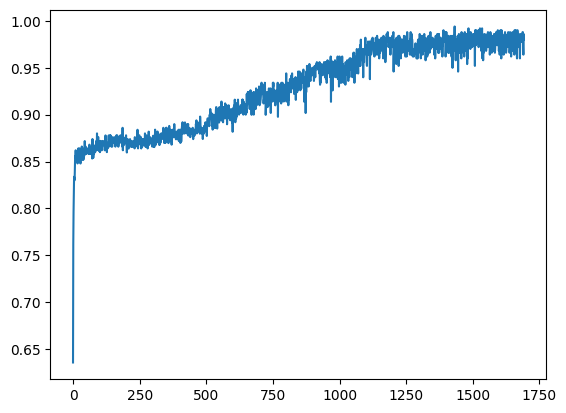

In [11]:
plt.plot(train_outputs["fscore"])

In [12]:
y_pred_scaled = model.forward(X_test_scaled)
y_pred = (y_pred_scaled > 0.5) * 1

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.9005193297033041


## Softmax

In [58]:
y_train_onehot = mf.onehot_encode(y_train, 2)
y_test_onehot = mf.onehot_encode(y_test, 2)

In [59]:
model = mc.Sequential(
    mc.Linear(2, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 2, init="uniform"),
    mc.Softmax(),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.001)
loss = CategorialCorssEntropy()

train_dataloader = NumpyClassificationDataloader(X_train_scaled, y_train_onehot, batch_size=20, shuffle=True, is_one_hot=True)
validation_dataloader = NumpyClassificationDataloader(X_test_scaled, y_test_onehot, batch_size=100, is_one_hot=True)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=200, metric="fscore", mode="max")
])
train_outputs_clas = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 1176


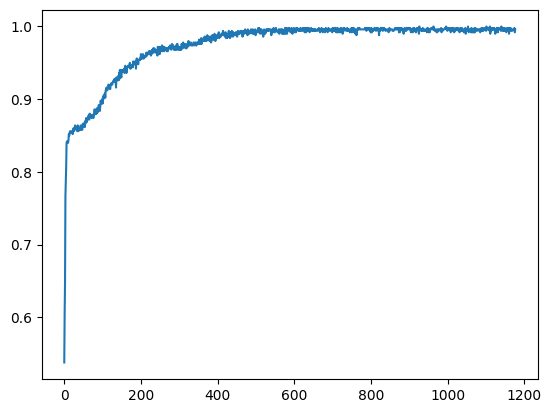

In [60]:
plt.plot(train_outputs_clas["fscore"])

In [61]:
y_pred_scaled = model.forward(X_test_scaled)
y_pred = np.argmax(y_pred_scaled, axis=1)

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.9450717119316449


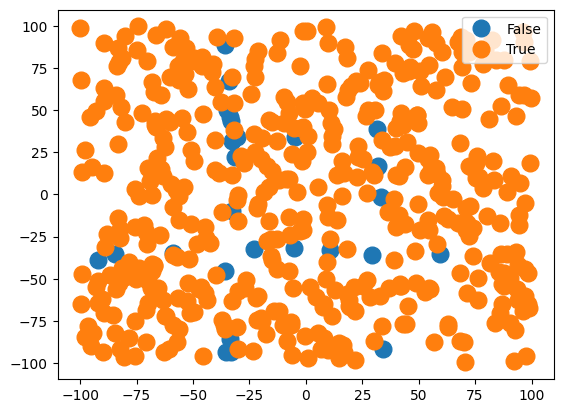

In [62]:
pred_test_df = pd.DataFrame({
    "x": X_test[:, 0],
    "y": X_test[:, 1],
    "c": y_pred == y_test.reshape(-1)
})
groups = pred_test_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend(loc="upper right")

In [63]:
print(model)

Sequential(
	Linear(input_size=2, output_size=10, init=he),
	ReLU(),
	Linear(input_size=10, output_size=10, init=he),
	ReLU(),
	Linear(input_size=10, output_size=10, init=he),
	ReLU(),
	Linear(input_size=10, output_size=2, init=uniform),
	Softmax()
)


Text(0.5, 1.0, 'Wizualizacja zbioru testowego xor3')

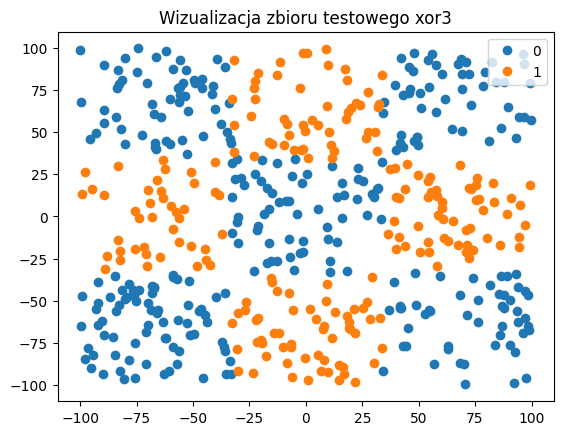

In [66]:
groups = test_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, label=name*1)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru testowego xor3")

Text(0.5, 1.0, 'Wizualizacja poprawności predykcji na zbiorze xor3')

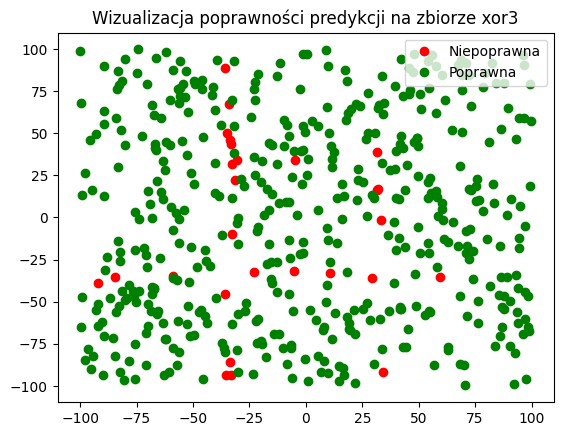

In [65]:

y_pred = model.forward(X_test_scaled)
y_pred = mf.onehot_decode(y_pred)

compare_df = pd.DataFrame(X_test, columns=["x", "y"])
compare_df["c"] = y_pred == y_test.flatten()

groups = compare_df.groupby('c')
for name, group in groups:
    if name:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="green", label="Poprawna")
    else:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="red", label="Niepoprawna")


plt.legend(loc="upper right")
plt.title("Wizualizacja poprawności predykcji na zbiorze xor3")

# Binary with MSE

In [19]:
model = mc.Sequential(
    mc.Linear(2, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.001)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train, batch_size=20, shuffle=True)
validation_dataloader = NumpyRegressionDataloader(X_test_scaled, y_test, batch_size=100)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=200, metric="fscore", mode="max")
])
train_outputs_bin = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

/home/zetrext/Code/MIOwAD/mygrad/mygrad/functional.py:47: RuntimeWarning: invalid value encountered in divide
  recall = tp / np.sum(y_true, axis=0)


Early stopping at epoch 678


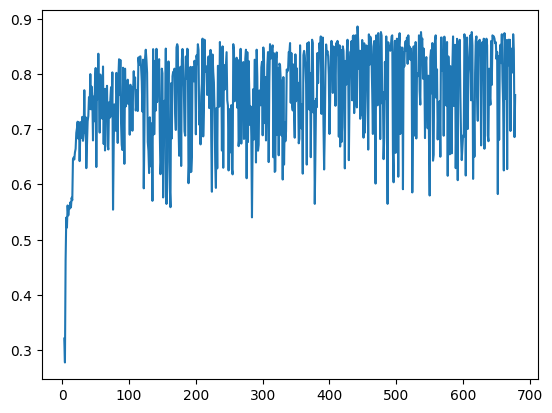

In [20]:
plt.plot(train_outputs_bin["fscore"])

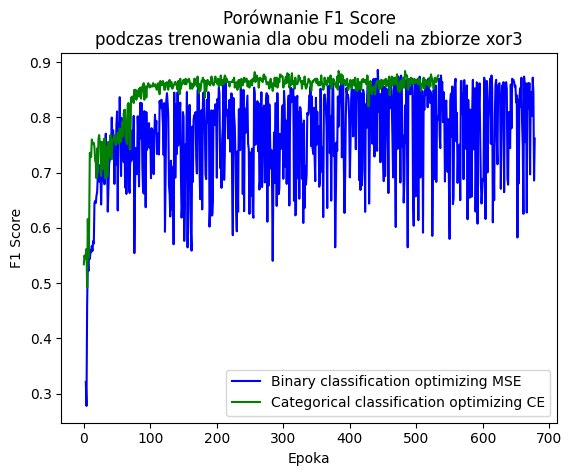

In [21]:
plt.plot(train_outputs_bin["fscore"], "b", label = "Binary classification optimizing MSE")
plt.plot(train_outputs_clas["fscore"], "g", label = "Categorical classification optimizing CE")
plt.legend()
plt.xlabel("Epoka")
plt.ylabel("F1 Score")
plt.title("Porównanie F1 Score\npodczas trenowania dla obu modeli na zbiorze xor3")
plt.show()